In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import backend as K
import tensorflow as tf

from nw2vec import utils, ae, layers, codecs

Using TensorFlow backend.


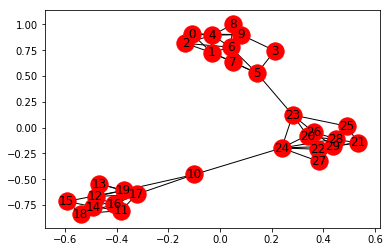

In [3]:
l = 3
k = 10
p_in = .5
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)
nx.draw_networkx(g)

In [3]:
adj = nx.adjacency_matrix(g).todense().astype(np.float32)
adjeye = adj + np.eye(len(g))

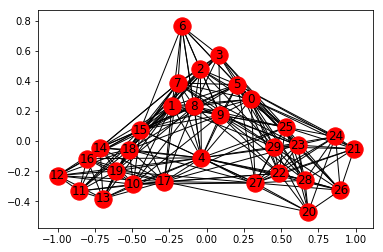

In [4]:
nx.draw_networkx(nx.from_numpy_array(adjeye ** 2))

In [7]:
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
features = labels
dims = (3, 5, 2)
q, q_codecs = ae.build_q(adj, dims)
p, p_codecs = ae.build_p(adj, dims)
vae, vae_codecs = ae.build_vae(adj, (q, q_codecs), (p, p_codecs), 6, [1.0, 1.0, 1.0])

ValueError: Shapes (?, ?, ?, ?) and (6, 30, 30) are incompatible

In [5]:
def max_layer_depth(model, target_layer_class):
    return np.max([_max_layer_depth_from_layer(layer, target_layer_class)
                   for layer in model.output_layers])

def _max_layer_depth_from_layer(layer, target_layer_class):
    inbound_layers = [inlayer
                      for innode in layer._inbound_nodes
                      for inlayer in innode.inbound_layers]
    if len(inbound_layers) == 0:
        parent_depth = 0
    else:
        parent_depth = np.max([_max_layer_depth_from_layer(inlayer, target_layer_class)
                               for inlayer in inbound_layers])
    return isinstance(layer, target_layer_class) + parent_depth

In [10]:
max_layer_depth(vae, layers.GC)

NameError: name 'vae' is not defined

In [22]:
in1 = keras.layers.Input(shape=(5,))
cut1 = keras.layers.Lambda(lambda x: x[:2])(in1)
bilin1 = layers.Bilinear(0, 2)([cut1, cut1])
m = keras.Model(inputs=in1, outputs=bilin1)
m.compile('adam', loss=lambda y_true, y_pred: K.sum(y_pred, axis=[1]))

steps_per_epoch = 4

def gen():
    while True:
        for i in range(steps_per_epoch):
            yield (np.ones((3, 5)), np.ones((2, 2)))

m.fit_generator(gen(), epochs=5, steps_per_epoch=steps_per_epoch, shuffle=False, check_array_lengths=False)

Epoch 1/5
4/4 [==============================] - 0s 57ms/step - loss: -1.8667
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: -2.0714
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: -2.2794
Epoch 4/5
4/4 [==============================] - 0s 4ms/step - loss: -2.4876
Epoch 5/5
4/4 [==============================] - 0s 3ms/step - loss: -2.6957


In [25]:
m.predict_on_batch(np.ones((3, 5))).sum(1)

array([-2.8257458, -2.8257458], dtype=float32)

In [35]:
K.eval(K.mean(K.ones((5, 4))))

1.0

In [118]:
# TODO:
# - allow for sampling of neighbours, i.e. don't take them all or this will grow very fast

def batches(features, adj, neighbour_depth, batch_size):
    # Check the adjacency matrix is:
    # - undirected
    # - unweighted
    # - with no diagonal elements
    n_nodes = adj.shape[0]
    assert len(features) == n_nodes
    assert (adj.T == adj).all()
    assert ((adj == 0) | (adj == 1)).all()
    assert np.trace(adj) == 0
    
    # Get the adjacency matrix for all paths of all lengths <= neighbour_depth
    adj_deep = np.sum([adj ** depth for depth in range(1, neighbour_depth + 1)], axis=0)

    # Shuffle the node indices, to group-iterate through them
    order = np.arange(n_nodes)
    np.random.shuffle(order)

    for batch_ids in utils.grouper(order, batch_size):
        # Prepare batch_ids
        batch_ids = np.array(batch_ids)
        if None in batch_ids:
            # Cut off `None`s
            batch_ids = batch_ids[:np.where(batch_ids == None)[0][0]].astype(order.dtype)
        
        # Get the neighbours of the target nodes
        sorted_neighbour_ids = np.where(adj_deep[batch_ids].sum(0))[0]
        # Merge all the required nodes into a single list, and shuffle that
        all_ids = np.array(list(set(batch_ids).union(sorted_neighbour_ids)))
        np.random.shuffle(all_ids)
        # Recover the indices of the target nodes in our shuffled extended list
        batch_mask = (all_ids[:, None] == batch_ids[None, :]).any(axis=-1)
        
        # Yield:
        # - the row-shuffled matrix of features of the nodes in the batch (with required neighbours included)
        # - the ids *in the previous list* of the target nodes
        # - the adjacency matrix for the nodes in the batch (with required neighbours included),
        #   ordered by the first matrix yielded: the matrix of features can be multiplied with this adjacency matrix.
        yield features[all_ids], np.where(batch_mask)[0], adj[all_ids, :][:, all_ids]

In [120]:
for batch_lists in batches(np.eye(adj.shape[0]), adj.todense(), 2, 4):
    print(batch_lists)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 